In [1]:
import numpy as np
import time
from scipy import stats
import matplotlib.pyplot as plt
% matplotlib inline

### Game Graph Class

In [2]:
class node:
    '''A simple node in a binary tree'''
    def __init__(self, value=None, left=None, right=None, parent=None):
        self.value = value
        self.left = left
        self.right = right
        self.parent = parent
        
def make_children(source):
    '''Creates and returns left and right children for source node'''
    left = node(parent=source)
    right = node(parent=source)
    source.left = left
    source.right = right
    return left, right

def make_tree(n):
    '''Builds a tree of depth n'''
    source = node()
    tree = [[] for i in range(n+1)]  # i is depth
    tree[0].append(source)
    
    # Add children depth-by-depth
    for i in range(n):
        for j in range(pow(2, i)):
            tree[i+1]+=make_children(tree[i][j])
    
    # Compute random leaf values
    for leaf in tree[-1]:
        leaf.value = 2*np.random.random()-1
#     for j in range(pow(2, n)):
#         tree[n][j].value = np.random.random()
        
    return tree

def print_tree(tree):
    '''Prints value of all nodes in tree by depth'''
    for d, l in enumerate(tree):
        vals = [v.value for v in l]
        print('Depth {} has {} nodes: {}'.format(d, len(vals), vals))
    print('')

### Value Calculation

In [3]:
# Example tree:
tree4 = make_tree(4)
# for v in tree4[-1]:
#     v.value=np.random.random()

def DFS_visit(node, Paul=True):
    '''Computes the value for each node'''
    if not node.value:
        DFS_visit(node.left, Paul=not Paul)
        DFS_visit(node.right, Paul=not Paul)
        if node.left.value:
            if node.right.value:
                if Paul:
                    node.value = max(node.left.value, node.right.value)
                else:
                    node.value = min(node.left.value, node.right.value)             
                    
# Example calculation:                    
DFS_visit(tree4[0][0])
print_tree(tree4)
print('The value to the first player, Paul, is: {}'.format(tree4[0][0].value))

Depth 0 has 1 nodes: [0.03480638992966534]
Depth 1 has 2 nodes: [0.03480638992966534, -0.8798455474631539]
Depth 2 has 4 nodes: [0.7543114912625863, 0.03480638992966534, -0.8798455474631539, -0.8187867220037663]
Depth 3 has 8 nodes: [0.13878630687353377, 0.7543114912625863, 0.03480638992966534, -0.7274386980922611, -0.8798455474631539, -0.8982816076411648, -0.8187867220037663, -0.919504416526441]
Depth 4 has 16 nodes: [0.32393925537934143, 0.13878630687353377, 0.7543114912625863, 0.9410712670504009, 0.3349812693427394, 0.03480638992966534, 0.5903510178813189, -0.7274386980922611, 0.7567046585802946, -0.8798455474631539, -0.024154434182661166, -0.8982816076411648, -0.8187867220037663, 0.9841440664156147, 0.5613874646505879, -0.919504416526441]

The value to the first player, Paul, is: 0.03480638992966534


### Simulations
#### 1 Advantage to playing last? Test the effect of parity of tree depth.

In [4]:
ks = np.random.randint(5, 10, 100)
even_numbers = 2*ks
plus_or_minus = np.random.choice((1, -1))
odd_numbers = even_numbers + plus_or_minus

t0 = time.time()
even_trees = [make_tree(n) for n in even_numbers]
t1 = time.time()
print('Time to make all even trees: {} sec'.format(t1 - t0))

odd_trees = [make_tree(n) for n in odd_numbers]

t0 = time.time()
for tree in even_trees:
    DFS_visit(tree[0][0])
t1 = time.time()
print('Time to compute values for all even trees: {} sec'.format(t1 - t0))

for tree in odd_trees:
    DFS_visit(tree[0][0])    

Time to make all even trees: 25.07368516921997 sec
Time to compute values for all even trees: 5.799424409866333 sec


In [5]:
odd_values = [tree[0][0].value for tree in odd_trees]
even_values = [tree[0][0].value for tree in even_trees]
print('Mean value to Paul for odd trees: {}\nMean value to Paul for even trees: {}'.format(np.mean(odd_values), np.mean(even_values)))
stats.ttest_ind(odd_values, even_values, equal_var=False)
# No advantage to playing last if pvalue > 0.05
# Advantage to playing last if pvalue < 0.05

Mean value to Paul for odd trees: 0.2530123604360265
Mean value to Paul for even trees: -0.2305412338015726


Ttest_indResult(statistic=58.88481036679881, pvalue=1.0715094323909765e-122)

#### 2. Advantage to playing first? Run t-test on all results against 0.

In [6]:
values = odd_values + even_values
print('Mean value to Paul for odd and even trees: {}'.format(np.mean(values)))
stats.ttest_1samp(values, popmean=0)
# No advantage to playing first if pvalue > 0.05
# Advantage to playing first if pvalue < 0.05

Mean value to Paul for odd and even trees: 0.011235563317226891


Ttest_1sampResult(statistic=0.63759973075282861, pvalue=0.52446719522623386)

#### 3. Variance

In [7]:
ns = [15]*100
trees15 = [make_tree(n) for n in ns]
for tree in trees15:
    DFS_visit(tree[0][0])

values = [tree[0][0].value for tree in trees15]
print('The average value for the first player, Paul, is: %.2f'%np.mean(values))
print('The standard deviation for the value for the first player, Paul, is: %.2f'%np.std(values))

The average value for the first player, Paul, is: 0.25
The standard deviation for the value for the first player, Paul, is: 0.03


#### 4. Plot distribution of results

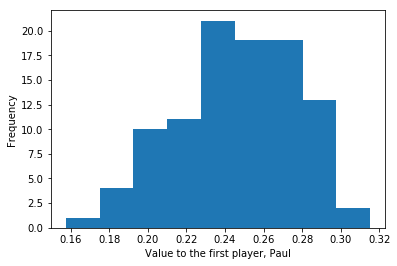

In [8]:
n, bins, patches = plt.hist(values, bins=9)
#means = [np.mean([edge, bins[i+1]]) for i, edge in enumerate(bins[:-1])]
#plt.plot(means, n, color='skyblue')
plt.xlabel('Value to the first player, Paul')
plt.ylabel('Frequency')
plt.show()

#### 5. Determine $\lim_{n\rightarrow \infty}Value[s]$

In [9]:
# ## Caution: this takes long unless you add alpha-beta pruning!
# ### It likely kills the kernel
# large_tree = make_tree(40)
# time0 = time.time()
# DFS_visit(large_tree[0][0])
# time1 = time.time()
# print("Large tree value computation took %.3f seconds."(time1 - time0))